### Text Processing for Author Recognition using Spark

#### Import statements

In [1]:
import pyspark as ps    # import the spark suite
import warnings         # display warning if spark context already exists
import os
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, StringType, FloatType
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
% matplotlib inline
import pandas as pd
import numpy as np
from pyspark.sql.functions import mean as sql_mean

#### Initialized Spark Context

In [2]:
try:
    sc = ps.SparkContext('local[4]') # create spark context to work locally on all available cpus
    print('created SparkContext')
except ValueError:
    warnings.warn('SparkContext already exists')    # issue a warning if context already exists

created SparkContext


### Read data.json into Spark SQL context

In [3]:
spark = ps.SQLContext(sc)
print('created SQLContext')

created SQLContext


In [4]:
data_file = 'data/data.json'
df = spark.read.json(data_file)

CONSIDER:

for fun use RDD and map reduce to remove the double bars I put into the excerpts!

In [5]:
print df.printSchema()
print df.count()
df.show(3)

root
 |-- author: string (nullable = true)
 |-- excerpt: string (nullable = true)
 |-- title: string (nullable = true)

None
9050
+----------+--------------------+-----------------+
|    author|             excerpt|            title|
+----------+--------------------+-----------------+
|JaneAusten|Chapter 1 || It i...|PrideAndPrejudice|
|JaneAusten|“What is his name...|PrideAndPrejudice|
|JaneAusten|“In such cases, a...|PrideAndPrejudice|
+----------+--------------------+-----------------+
only showing top 3 rows



### Here we import some sql funtions and give our dataframe a SQL table name

In [6]:
from pyspark.sql.functions import length
from pyspark.sql.functions import count

df.createOrReplaceTempView("excerpts")

In [7]:
sqlDF = spark.sql("SELECT count(*) FROM excerpts WHERE author = 'MarkTwain'")
sqlDF.show()

+--------+
|count(1)|
+--------+
|    2284|
+--------+



### Lambda functions are created to explore the the character count, word count, and average word length and then add them to the dataframe.

In [8]:
def char_count(text):
    return len(text)

def word_count(text):
    return len(text.split())

def avg_word_length(text):
    return sum([len(t) for t in text.split()]) / float(len(text.split()))

def sentence_count(text):
    return len(text.split('.'))

def sentence_length(text):
    return sum([len(t.split()) for t in text.split('.')]) / float(len(text.split('.'))) 

def tokenize_excerpt(text):
    stops = set(stopwords.words('english'))  # get a set of english stop words
    unpunctuated_text = text.translate(None, string.punctuation)  # remove punctuation
    tokens = word_tokenize(unpunctuated_text)  # tokenize
    cleaned_tokens = [t.lower() for t in tokens if t.lower() not in stops]  # remove stopwords, lowercase everything
    return cleaned_tokens

def avg_word_length2(tokens):
    return sum([len(t) for t in tokens])
#     return sum([len(t) for t in tokens]) / float(len(tokens))
#     return sum([len(t) for t in text.split()]) / float(len(text.split()))

In [10]:
charcount_udf = udf(lambda x : char_count(x))
wordcount_udf = udf(lambda x: word_count(x))
avgwordlen_udf = udf(lambda x: avg_word_length(x))
sentencecount_udf = udf(lambda x: sentence_count(x))
sentencelength_udf = udf(lambda x: sentence_length(x))
tokenize_udf = udf(lambda x: tokenize_excerpt(x))
wordlen2_udf = udf(lambda x: avg_word_length2(x))

df2 = df.withColumn("character_count", charcount_udf(df.excerpt).cast(FloatType())) \
        .withColumn("word_count", wordcount_udf(df.excerpt).cast(FloatType())) \
        .withColumn("avg_wordlen", avgwordlen_udf(df.excerpt).cast(FloatType())) \
        .withColumn("sent_count", sentencecount_udf(df.excerpt).cast(FloatType())) \
        .withColumn("sent_length", sentencelength_udf(df.excerpt).cast(FloatType())) \
        .withColumn("tokenized", tokenize_udf(df.excerpt))
    
df3 = df2.withColumn("w2", wordlen2_udf(df2.excerpt).cast(FloatType()))

In [13]:
df3.createOrReplaceTempView("excerpts")
# sqlDF = spark.sql("SELECT author, AVG(avg_wordlen), AVG(word_count), AVG(sent_length) FROM excerpts GROUP BY author")
sqlDF = spark.sql("SELECT author, AVG(avg_wordlen), AVG(word_count), AVG(sent_length), AVG(w2) FROM excerpts GROUP BY author")
sqlDF.show(20)

+--------------+-----------------+------------------+------------------+------------------+
|        author| avg(avg_wordlen)|   avg(word_count)|  avg(sent_length)|           avg(w2)|
+--------------+-----------------+------------------+------------------+------------------+
|     MarkTwain|4.453468537894314|283.86646234676004| 25.14267813893208|1549.5621716287214|
|      JohnMuir|4.655685173381459|325.68848484848485|27.422324373071845|1839.7769696969697|
|    JaneAusten|4.550830074074491|272.27123633305297| 22.02252339073547| 1511.313708999159|
|CharlesDickens| 4.42506248737499| 246.0895312938535|21.195489508029016|1334.9643558798766|
+--------------+-----------------+------------------+------------------+------------------+



In [17]:

sqlDFTwain = spark.sql("SELECT character_count, avg_wordlen, word_count, sent_length FROM excerpts WHERE author = 'MarkTwain' AND sent_length <=100")
sqlDFMuir = spark.sql("SELECT character_count, avg_wordlen, word_count, sent_length FROM excerpts WHERE author = 'JohnMuir' AND sent_length <=100")
sqlDFAusten = spark.sql("SELECT character_count, avg_wordlen, word_count, sent_length FROM excerpts WHERE author = 'JaneAusten' AND sent_length <=100")
sqlDFDickens = spark.sql("SELECT character_count, avg_wordlen, word_count, sent_length FROM excerpts WHERE author = 'CharlesDickens' AND sent_length <=100")


In [35]:
def make_plots(DFs, col, bins, title, colors, x_lab, authors, x_lim=None):
    plt.subplots(4,4,sharex=True, sharey=True, figsize=(8,8))
    plt.tight_layout()
    plt.subplots_adjust(top=0.92)
    plt.suptitle(title, fontsize=18)
    for i, DF in enumerate(DFs):
        make_hist(DF, col, bins, colors[i], x_lim, i, x_lab, authors[i])
                
def make_hist(DF, col, bins, color, x_lim, i, x_lab, author):
    # Create pandas DF of bins and counts
    test_histogram = DF.select(col).rdd.flatMap(lambda x: x).histogram(bins)
    temp_df = pd.DataFrame(zip(list(test_histogram)[0],
                                list(test_histogram)[1]),columns=['Bin','Frequency'])
    plt.subplot(2,2,i+1)
    weights = temp_df.Frequency/temp_df.Frequency.sum()
    plt.hist(temp_df.Bin, bins, weights=weights, color=color, 
             alpha=0.2, label=author)
    # Find mean sentence length
    x_val = DF.select(sql_mean(col)).select('avg('+col+')').head()[0]
    plt.axvline(x=x_val, color=color, label="Mean")
    plt.xlabel(x_lab)
    plt.ylabel("Frequency")
    plt.xlim(x_lim)
    plt.legend();

In [27]:
DFs = [sqlDFTwain, sqlDFMuir, sqlDFAusten, sqlDFDickens]
authors = ["Twain", "Muir", "Austen", "Dickens"]
colors = ['g', 'b', 'r', 'c']

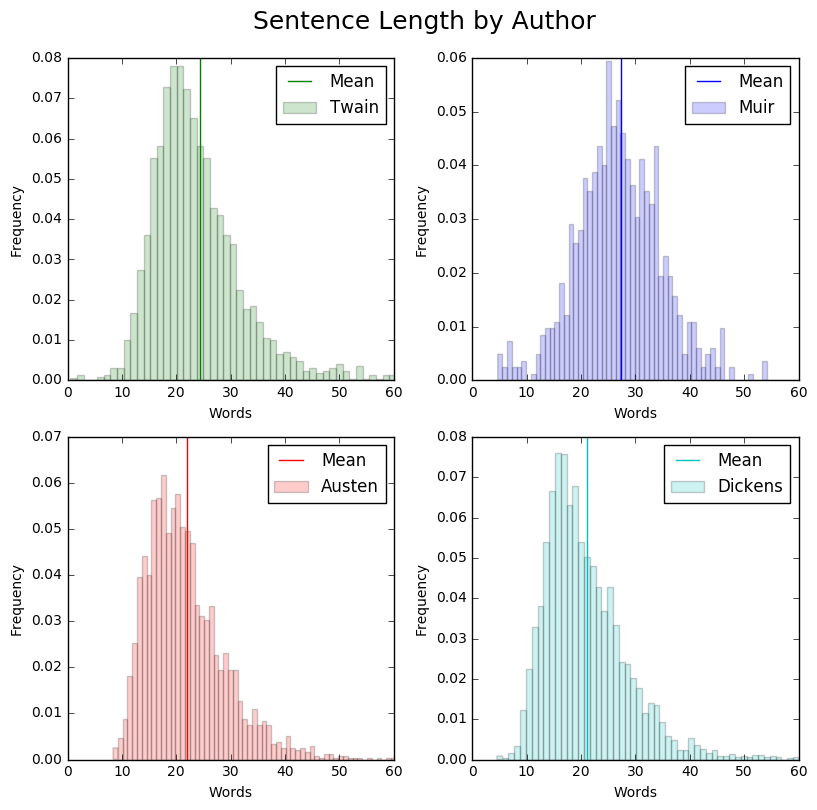

In [28]:
# Make Sentence Length Histograms

make_plots(DFs=DFs, col='sent_length', bins=75, title='Sentence Length by Author',
           colors=colors, x_lim=(0,60), x_lab="Words", authors=authors)

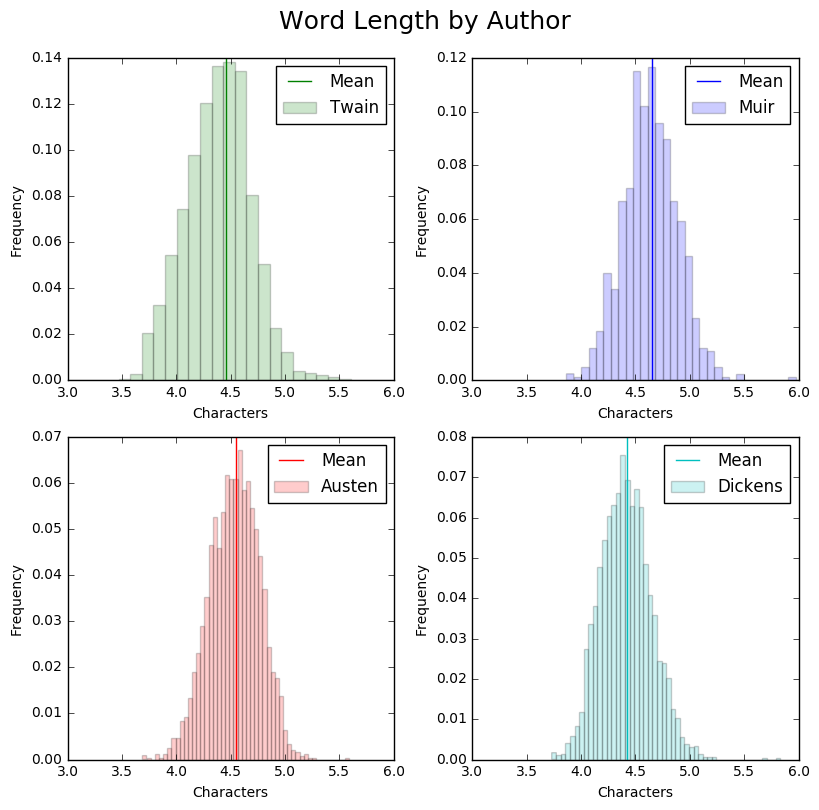

In [36]:
# Make Word Length Histograms

make_plots(DFs=DFs, col='avg_wordlen', bins=50, title='Word Length by Author',
           colors=colors, x_lim=(3,6), x_lab="Characters", authors=authors)